In [82]:
#imports

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split as tts, KFold
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.datasets import make_spd_matrix
from scipy.optimize import minimize
from scipy.linalg import toeplitz
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score as R2



In [49]:
#Reused Classes for part 2

class ElasticNet(nn.Module):
    def __init__(self, input_size, alpha=1.0, l1_ratio=0.5, dtype = torch.float64):
        """
        Initialize the ElasticNet regression model.

        Args:
            input_size (int): Number of input features.
            alpha (float): Regularization strength. Higher values of alpha
                emphasize L1 regularization, while lower values emphasize L2 regularization.
            l1_ratio (float): The ratio of L1 regularization to the total
                regularization (L1 + L2). It should be between 0 and 1.

        """
        super(ElasticNet, self).__init__()
        self.input_size = input_size
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.dtype = dtype

        # Define the linear regression layer
        self.linear = nn.Linear(input_size, 1,dtype = self.dtype)

    def forward(self, x):
        """
        Forward pass of the ElasticNet model.

        Args:
            x (Tensor): Input data with shape (batch_size, input_size).

        Returns:
            Tensor: Predicted values with shape (batch_size, 1).

        """
        return self.linear(x)

    def loss(self, y_pred, y_true):
        """
        Compute the ElasticNet loss function.

        Args:
            y_pred (Tensor): Predicted values with shape (batch_size, 1).
            y_true (Tensor): True target values with shape (batch_size, 1).

        Returns:
            Tensor: The ElasticNet loss.

        """
        mse_loss = nn.MSELoss()(y_pred, y_true)
        l1_reg = torch.norm(self.linear.weight, p=1)
        l2_reg = torch.norm(self.linear.weight, p=2)

        loss = mse_loss + self.alpha * (
            self.l1_ratio * l1_reg + (1 - self.l1_ratio) * l2_reg
        )

        return loss
    def fit(self, X, y, num_epochs=100, learning_rate=0.01):
        """
        Fit the ElasticNet model to the training data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).
            y (Tensor): Target values with shape (num_samples, 1).
            num_epochs (int): Number of training epochs.
            learning_rate (float): Learning rate for optimization.

        """
        optimizer = optim.SGD(self.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            self.train()
            optimizer.zero_grad()
            y_pred = self(X)
            loss = self.loss(y_pred, y)
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

    def predict(self, X):
        """
        Predict target values for input data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).

        Returns:
            Tensor: Predicted values with shape (num_samples, 1).

        """
        self.eval()
        with torch.no_grad():
            y_pred = self(X)
        return y_pred
    def get_coefficients(self):
        """
        Get the coefficients (weights) of the linear regression layer.

        Returns:
            Tensor: Coefficients with shape (output_size, input_size).

        """
        return self.linear.weight
    
class sqrtLasso(nn.Module):
    def __init__(self, input_size, alpha=0.1, dtype = torch.float64):
        """
        Initialize the  regression model.


        """
        super(sqrtLasso, self).__init__()
        self.input_size = input_size
        self.alpha = alpha
        self.dtype = dtype


        # Define the linear regression layer
        self.linear = nn.Linear(input_size, 1, dtype = self.dtype)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (Tensor): Input data with shape (batch_size, input_size).

        Returns:
            Tensor: Predicted values with shape (batch_size, 1).

        """
        return self.linear(x)

    def loss(self, y_pred, y_true):
        """
        Compute the loss function.

        Args:
            y_pred (Tensor): Predicted values with shape (batch_size, 1).
            y_true (Tensor): True target values with shape (batch_size, 1).

        Returns:
            Tensor: The loss.

        """
        mse_loss = nn.MSELoss()(y_pred, y_true)
        l1_reg = torch.norm(self.linear.weight, p=1,dtype=torch.float64)
        # l2_reg = torch.norm(self.linear.weight, p=2,dtype=torch.float64)

        loss = (len(y_true)*mse_loss)**(1/2) + self.alpha * (l1_reg)

        return loss

    def fit(self, X, y, num_epochs=200, learning_rate=0.01):
        """
        Fit the model to the training data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).
            y (Tensor): Target values with shape (num_samples, 1).
            num_epochs (int): Number of training epochs.
            learning_rate (float): Learning rate for optimization.

        """
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            self.train()
            optimizer.zero_grad()
            y_pred = self(X)
            loss = self.loss(y_pred, y)
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

    def predict(self, X):
        """
        Predict target values for input data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).

        Returns:
            Tensor: Predicted values with shape (num_samples, 1).

        """
        self.eval()
        with torch.no_grad():
            y_pred = self(X)
        return y_pred
    def get_coefficients(self):
        """
        Get the coefficients (weights) of the linear regression layer.

        Returns:
            Tensor: Coefficients with shape (output_size, input_size).

        """
        return self.linear.weight
    



In [50]:

'''
Loss function and SCAD Class 

Basically a rewrite of his function
'''
def scad_penalty_torch(beta_hat, lambda_val, a_val):

    
    is_linear = torch.abs(beta_hat) <= lambda_val
    is_quadratic = (lambda_val < torch.abs(beta_hat)) & (torch.abs(beta_hat) <= a_val * lambda_val)
    is_constant = (a_val * lambda_val) < torch.abs(beta_hat)

    linear_part = lambda_val * torch.abs(beta_hat) * is_linear.float()
    quadratic_part = (2 * a_val * lambda_val * torch.abs(beta_hat) - beta_hat**2 - lambda_val**2) / (2 * (a_val - 1)) * is_quadratic.float()
    constant_part = (lambda_val**2 * (a_val + 1)) / 2 * is_constant.float()

    return linear_part + quadratic_part + constant_part



class scadregression(nn.Module):
    def __init__(self, input_size, lambda_ = 1, a = 3, dtype = torch.float64):
        """
        lambda and a control loss function
        
        Dtype is defaulted to double


        """
        super(scadregression, self).__init__()
        self.input_size = input_size
        self.a = a
        self.lambda_ = lambda_
        self.dtype = dtype


        self.linear = nn.Linear(input_size, 1, dtype = self.dtype)

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (Tensor): Input data with shape (batch_size, input_size).

        Returns:
            Tensor: Predicted values with shape (batch_size, 1).

        """
        return self.linear(x)

    def loss(self, y_pred, y_true):
        """
        Compute the loss function.

        Args:
            y_pred (Tensor): Predicted values with shape (batch_size, 1).
            y_true (Tensor): True target values with shape (batch_size, 1).

        Returns:
            Tensor: The loss.

        """
        mse_loss = nn.MSELoss()(y_pred, y_true)
        
        scad_penalty_torch(self.linear.weight, self.lambda_, self.a)

        loss = mse_loss

        return loss

    def fit(self, X, y, num_epochs=200, learning_rate=0.01):
        """
        Fit the model to the training data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).
            y (Tensor): Target values with shape (num_samples, 1).
            num_epochs (int): Number of training epochs.
            learning_rate (float): Learning rate for optimization.

        """
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            self.train()
            optimizer.zero_grad()
            y_pred = self(X)
            loss = self.loss(y_pred, y)
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

    def predict(self, X):
        """
        Predict target values for input data.

        Args:
            X (Tensor): Input data with shape (num_samples, input_size).

        Returns:
            Tensor: Predicted values with shape (num_samples, 1).

        """
        self.eval()
        with torch.no_grad():
            y_pred = self(X)
        return y_pred
    def get_coefficients(self):
        """
        Get the coefficients (weights) of the linear regression layer.

        Returns:
            Tensor: Coefficients with shape (output_size, input_size).

        """
        return self.linear.weight

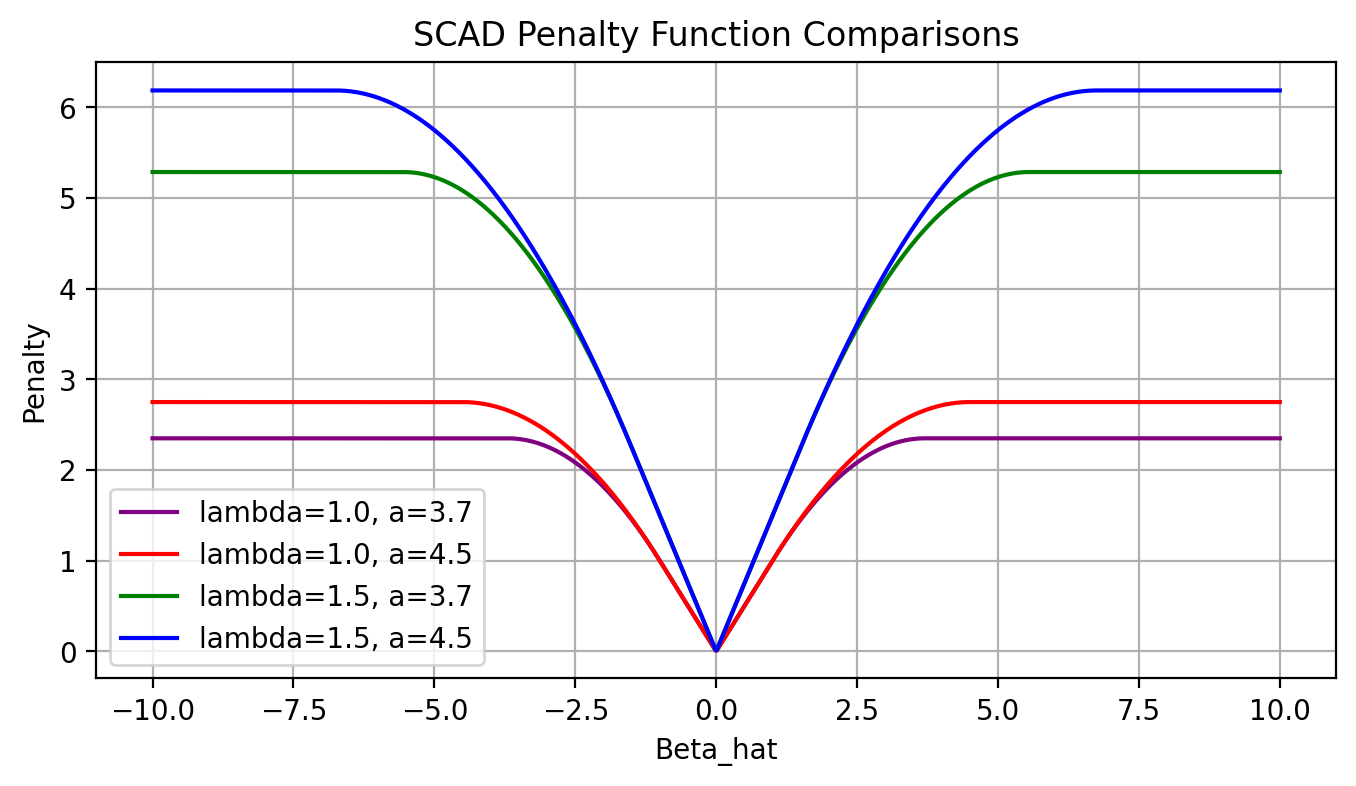

In [127]:
'''
Quick visulization to ensure functionalilty 
'''

lambda_vals = [1.0, 1.5]
a_vals = [3.7, 4.5]
colors = ['blue', 'green', 'red', 'purple']
labels = [
    f'lambda={lambda_vals[1]}, a={a_vals[1]}',
    f'lambda={lambda_vals[1]}, a={a_vals[0]}',
    f'lambda={lambda_vals[0]}, a={a_vals[1]}',
    f'lambda={lambda_vals[0]}, a={a_vals[0]}',
]


beta_hat = torch.linspace(-10, 10, 1000)

plt.figure(figsize=(8, 4))

for lambda_val in lambda_vals:
    for a_val in a_vals:
        penalty = scad_penalty_torch(beta_hat, torch.tensor(lambda_val), torch.tensor(a_val))
        plt.plot(beta_hat.numpy(), penalty.numpy(), label=labels.pop(), color=colors.pop())

plt.xlabel('Beta_hat')
plt.ylabel('Penalty')
plt.title('SCAD Penalty Function Comparisons')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
'''
Test your method one a real data set, and determine a variable selection based on features importance according to SCAD.

The data chose for this dataset is credit card fraud data. The intial goal of the data is to predict binary classes,
but I'm choosing to predict transaction size. The feature matrix containts 28 PCA features 

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
'''

In [85]:
#Reading in and preping data

df = pd.read_csv('creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [121]:
x = df.iloc[:,1:29].values[:10000,:]
y = df.iloc[:,29].values[:10000]

In [122]:
x

array([[-1.35980713, -0.07278117,  2.53634674, ..., -0.18911484,
         0.13355838, -0.02105305],
       [ 1.19185711,  0.26615071,  0.16648011, ...,  0.12589453,
        -0.0089831 ,  0.01472417],
       [-1.35835406, -1.34016307,  1.77320934, ..., -0.13909657,
        -0.05535279, -0.05975184],
       ...,
       [-0.97173366,  0.74462538,  2.33482193, ...,  0.7503226 ,
        -0.10787452,  0.03127173],
       [-1.52966552,  1.47586981,  1.50762389, ...,  0.61196377,
        -0.16978948,  0.00784609],
       [-1.1817211 ,  1.48526441,  1.95871523, ..., -0.03361201,
        -0.14268204,  0.02814863]])

In [123]:
y = y.reshape(-1,1)
y

array([[149.62],
       [  2.69],
       [378.66],
       ...,
       [  4.05],
       [  4.05],
       [159.28]])

In [124]:

#Fitting the model
device = torch.device("cpu")
x = torch.tensor(x,device=device)
y = torch.tensor(y,device=device)
model = scadregression(input_size=x.shape[1])
model.fit(x,y, num_epochs = 10000)

Epoch [100/10000], Loss: 36275.80665283979
Epoch [200/10000], Loss: 34755.26593907481
Epoch [300/10000], Loss: 33440.239879166314
Epoch [400/10000], Loss: 32277.356009879953
Epoch [500/10000], Loss: 31222.260240757394
Epoch [600/10000], Loss: 30243.765605340428
Epoch [700/10000], Loss: 29322.315887418812
Epoch [800/10000], Loss: 28445.50608428926
Epoch [900/10000], Loss: 27605.01439857964
Epoch [1000/10000], Loss: 26795.124116455303
Epoch [1100/10000], Loss: 26011.90573727587
Epoch [1200/10000], Loss: 25252.64638229147
Epoch [1300/10000], Loss: 24515.431445410974
Epoch [1400/10000], Loss: 23798.85362066151
Epoch [1500/10000], Loss: 23101.823904183628
Epoch [1600/10000], Loss: 22423.45537706607
Epoch [1700/10000], Loss: 21762.994037437693
Epoch [1800/10000], Loss: 21119.77796404665
Epoch [1900/10000], Loss: 20493.212842649496
Epoch [2000/10000], Loss: 19882.756824047814
Epoch [2100/10000], Loss: 19287.910772369003
Epoch [2200/10000], Loss: 18708.211713415636
Epoch [2300/10000], Loss: 18

In [125]:
#Quck test data check
x_test = df.iloc[:,1:29].values[10000:20000,:]
y_test = df.iloc[:,29].values[10000:20000]
y_test = y_test.reshape(-1,1)
x_test = torch.tensor(x_test,device=device)
y_test = torch.tensor(y_test,device=device)
mse(model.predict(x_test).numpy(), y_test)

6984.8339730113685

In [126]:
'''
It doesn't appear that any values are converging to zero, however the intial data was PCA features so we can assume
it wasn't sparse to begin with 

'''

model.get_coefficients()

Parameter containing:
tensor([[-47.7469, -85.6394, -41.2157,  25.8810, -72.6588,  39.0775,  74.1459,
         -17.5552,  -6.2659, -25.6157,   3.8683,  -1.2246,   5.9384,   8.4927,
           6.7144,   7.8139,   2.0306,   4.8274, -14.2638,  74.0393,  20.5055,
         -27.9408, -79.3978,   5.5875, -19.5590,  -2.7742,  20.5588,  -9.4952]],
       dtype=torch.float64, requires_grad=True)

In [15]:
def make_correlated_features(num_samples,p,rho):
    vcor = []
    for i in range(p):
        vcor.append(rho**i)
    r = toeplitz(vcor)
    mu = np.repeat(0,p)
    x = np.random.multivariate_normal(mu, r, size=num_samples)
    return x


In [ ]:
'''
Based on the simulation design explained in class, generate 500 data sets where the input features have a strong 
correlation structure (you may consider a 0.9) and apply ElasticNet, SqrtLasso and SCAD to check 
which method produces the best approximation of an ideal solution, such as a "betastar" 
you design with a sparsity pattern.

'''

In [66]:
scad = []
sqrt_lasso = []
elastic = []

rho = 0.9
p = 50
n = 25

#Number of beta values to be sampled from uniform (-10,10)
num_sampled_betas = 10

for _ in range(0,500):
    #creation of dataset, nonzero betas are generated randomly from uniform
    x = make_correlated_features(n,p,rho)
    beta =np.array([np.random.randint(-10,11) for x in range(0,num_sampled_betas)])
    beta = beta.reshape(-1,1)
    betastar = np.concatenate([beta,np.repeat(0,p-len(beta)).reshape(-1,1)],axis=0)
    y = x@betastar + 1.5*np.random.normal(size=(n,1))
    
    
    device = torch.device("cpu")
    x = torch.tensor(x,device=device)
    y = torch.tensor(y,device=device)
    
    model1 = scadregression(input_size=x.shape[1])
    model2 = sqrtLasso(input_size=x.shape[1])
    model3 = ElasticNet(input_size=x.shape[1])
    
    #Models are fitted with defualt hyperparameters, epochs kept low to avoid overfitting
    models = [model1, model2, model3]
    [model.fit(x,y, num_epochs = 5) for model in models]
    
    
    #MSE is taken between predicted coefficents and true 
    
    scad.append(mse(model1.get_coefficients().detach().numpy(), betastar.reshape(1,-1)))
    sqrt_lasso.append(mse(model2.get_coefficients().detach().numpy(), betastar.reshape(1,-1)))
    elastic.append(mse(model3.get_coefficients().detach().numpy(), betastar.reshape(1,-1)))

In [67]:
print('Scad MSE: 'sum(scad)/len(scad))

print('Sqrt Lasso MSE: 'sum(sqrt_lasso)/len(sqrt_lasso))

print('Elastic Net MSE: 'sum(elastic)/len(elastic))

6.6105138766096525
6.6098960311333155
5.9356359599274
